S3D shape: (135, 176)


<IPython.core.display.Javascript object>


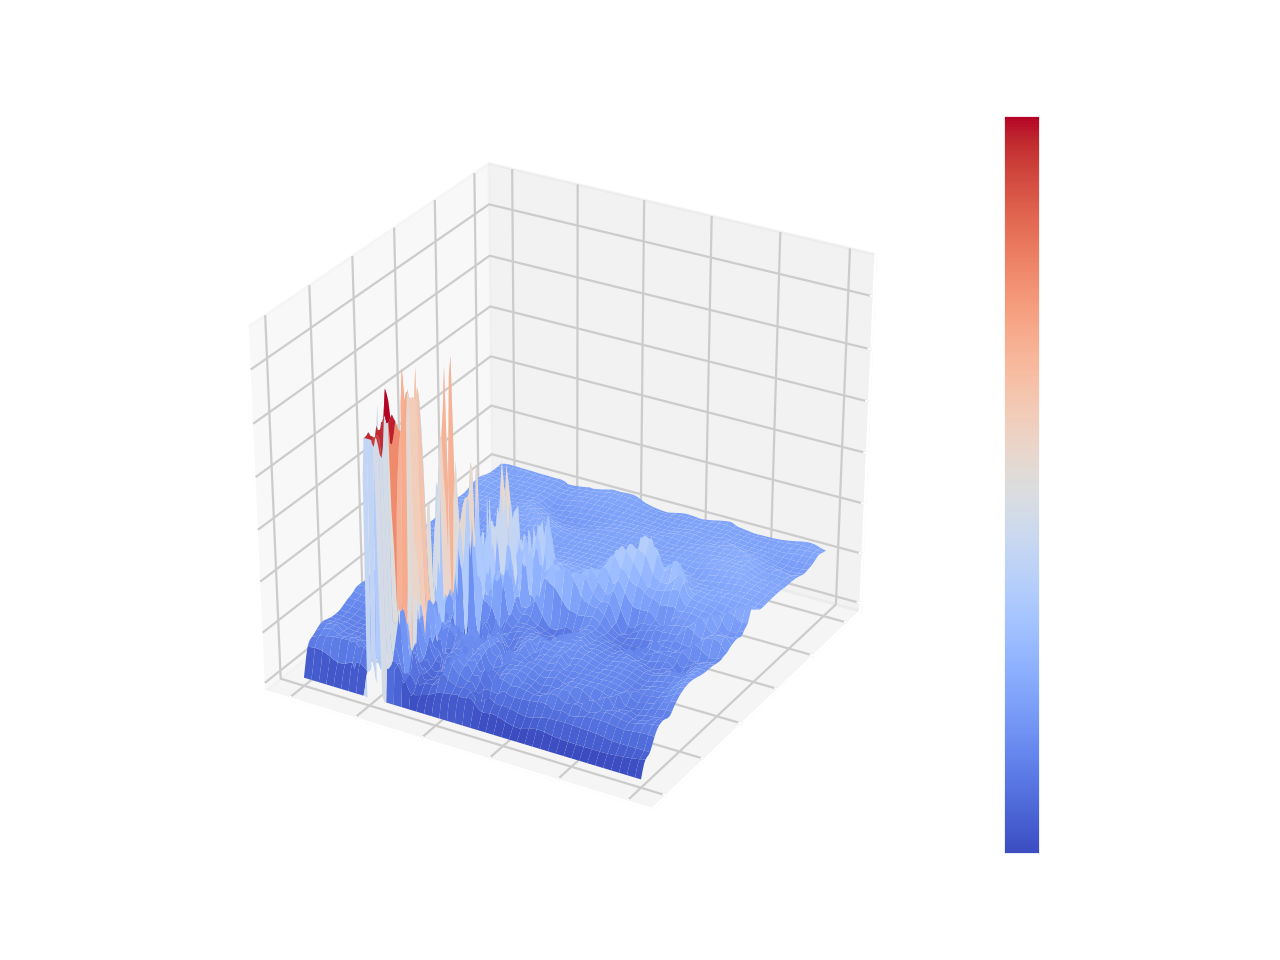

In [8]:
%matplotlib notebook
# import pixiedust
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import mpl_toolkits.mplot3d.axes3d as axes3d
from IPython.display import clear_output
from tqdm import tqdm
import itertools, collections
from scipy.ndimage import zoom

def plot3D(Z, x=None, y=None):
    if x is None:
        x = np.arange(Z.shape[1])
    if y is None:
        y = np.arange(Z.shape[0])
    X, Y = np.meshgrid(x, y)
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)
    fig.colorbar(surf)
    plt.show()

sincFunc = False

if sincFunc:
    nPointsX = 50
    nPointsY = 70
    scale    = 10
    shiftX   = 1.5
    shiftY   = -1.2
    Dmin     = -4.
    Dmax     = 4.
    x = np.linspace(Dmin, Dmax, nPointsX)
    y = np.linspace(Dmin, Dmax, nPointsY)
    X, Y = np.meshgrid(x+shiftX, y+shiftY)
    z = scale * np.sinc(np.sqrt(X**2 + Y**2))
else:
    binFactor = 4.0
    z = np.fromfile("s3d_2D.raw", dtype=np.float64).reshape(540,704)
    #z = np.fromfile("nek5000.raw", dtype=np.float64).reshape(200,200)
    z = zoom(z, 1./binFactor, order=4)
    print ("S3D shape:", z.shape)
    nPointsY = z.shape[0]
    nPointsX = z.shape[1]
    Dmin     = 0.
    Dmax     = 100.
    x = np.linspace(Dmin, Dmax, nPointsX)
    y = np.linspace(Dmin, Dmax, nPointsY)

zRange = z.max()-z.min()
plot3D(z, x, y)

<IPython.core.display.Javascript object>


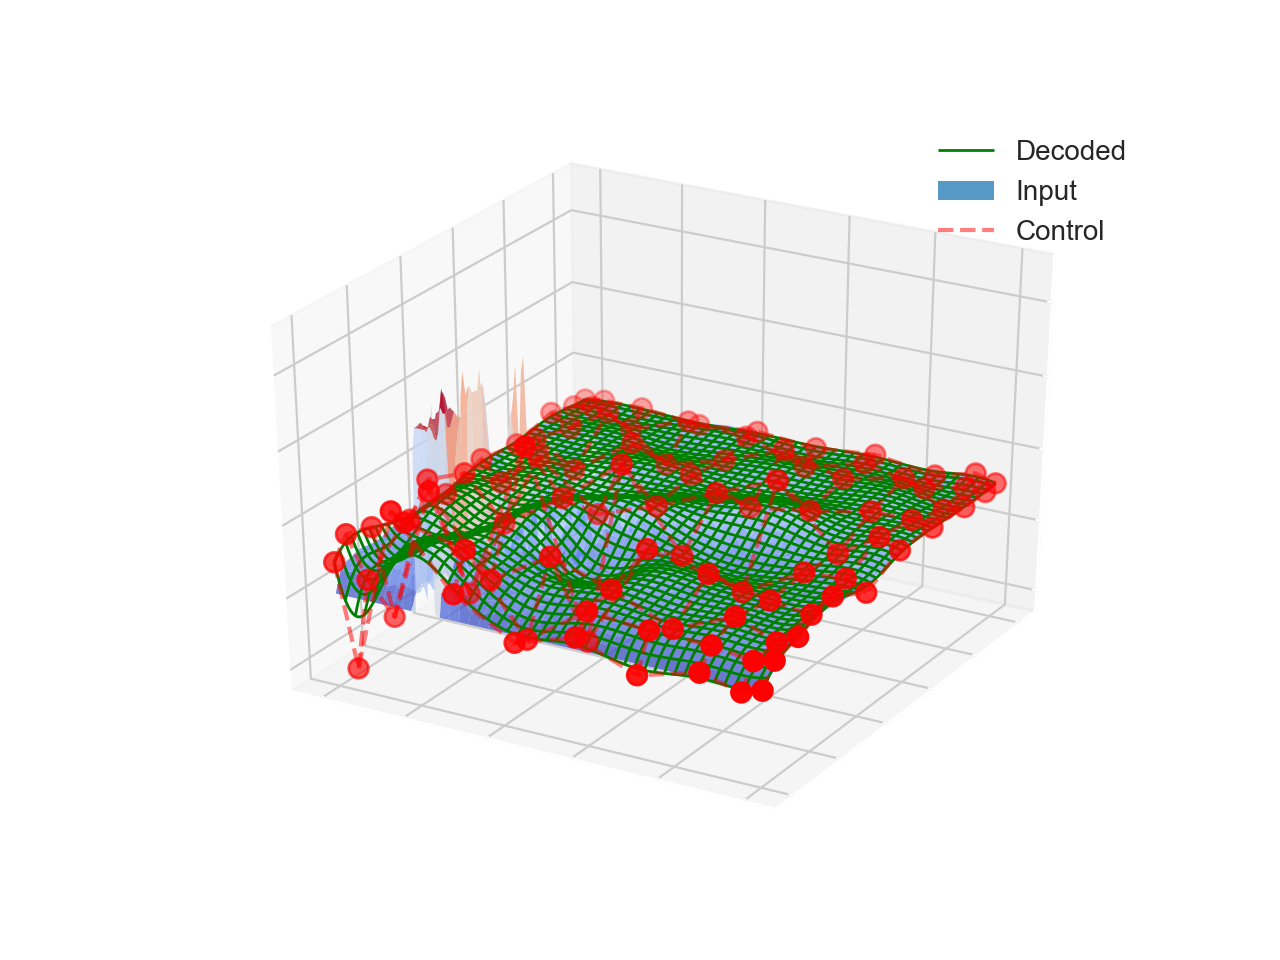

Ctrl points: (10, 10)
Sum of squared error: 7833390.278159502
Normalized mean squared error: 0.9885933949669463
Normalized max error: 0.7491586745512966


In [10]:
from scipy.interpolate import LSQUnivariateSpline, UnivariateSpline
from scipy.optimize import minimize, linprog, LinearConstraint
from scipy import linalg
import collections

degree             = 3
nControlPoints     = np.array([10, 10])
nControlPointSpans = nControlPoints - 1
nInternalKnotSpans = nControlPointSpans - degree + 1

inc  = 1. / nInternalKnotSpans
tu   = np.linspace(inc[0], 1-inc[0], nInternalKnotSpans[0] - 1)
tv   = np.linspace(inc[1], 1-inc[1], nInternalKnotSpans[1] - 1)
U    = np.linspace(0, 1, nPointsY)
V    = np.linspace(0, 1, nPointsX)
#U     = [Uy,Ux]
knotsU = np.concatenate(([0] * (degree+1), tu, [1] * (degree+1)))
knotsV = np.concatenate(([0] * (degree+1), tv, [1] * (degree+1)))
EPS    = 1e-32
GTOL   = 1e-2
basis  = lambda u,p,T: ((T[:-1]<=u) * (u<=T[1:])).astype(np.float) if p==0 else \
                    ((u - T[:-p]) /(T[p:]  -T[:-p]+EPS))[:-1] * basis(u,p-1,T)[:-1] + \
                    ((T[p+1:] - u)/(T[p+1:]-T[1:-p]+EPS))     * basis(u,p-1,T)[1:]

def getControlPoints(knots, k):
    nCtrlPts = len(knots) - 1 - k
    cx       = np.zeros(nCtrlPts)
    for i in range(nCtrlPts):
        tsum = 0
        for j in range(1, k + 1):
            tsum += knots[i + j]
        cx[i] = float(tsum) / k
    return cx

def decode(P, W, degree, Nu, Nv):
    Nu = Nu[...,np.newaxis]
    Nv = Nv[:,np.newaxis]
    NN = []
    for ui in range(Nu.shape[0]):
        for vi in range(Nv.shape[0]):
          NN.append(Nu[ui]*Nv[vi])  
    NN = np.array(NN)

    decoded = np.tensordot(NN, P * W) / np.tensordot(NN, W)
    return decoded.reshape((Nu.shape[0], Nv.shape[0]))
#     RNx = N[0] * np.sum(W, axis=0)
#     RNx /= np.sum(RNx, axis=1)[:,np.newaxis]
#     RNy = N[1] * np.sum(W, axis=1)
#     RNy /= np.sum(RNy, axis=1)[:,np.newaxis]
#     return np.matmul(np.matmul(RNx, P), RNy.T)

def Error(P, W, z, degree, Nu, Nv):
    return decode(P, W, degree, Nu, Nv) - z

def lsqFitWithCons(Nu, Nv, W, z, degree, cons=None, continuity=0):
    def l2(P, W, z, degree, Nu, Ny):
        return np.sum(Error(P.reshape(W.shape), W, z, degree, Nu, Nv)**2)
    res = minimize(l2, np.ones_like(W), method='SLSQP', args=(W, z, degree, Nu, Nv), 
                   constraints=cons,  options={'disp': True})
    return res.x, res.fun.tolist()
#https://www.geometrictools.com/Documentation/BSplineSurfaceLeastSquaresFit.pdf    
def lsqFit(Nu, Nv, W, z, degree, use_cho=True, constraints=None, continuity=0):
    if constraints is None or len(constraints)==0:
        RNx = Nu * np.sum(W, axis=1)
        RNx /= np.sum(RNx, axis=1)[:,np.newaxis]
        RNy = Nv * np.sum(W, axis=0)
        RNy /= np.sum(RNy, axis=1)[:,np.newaxis]
        if use_cho:
            X = linalg.cho_solve(linalg.cho_factor(np.matmul(RNx.T,RNx)), RNx.T)
            Y = linalg.cho_solve(linalg.cho_factor(np.matmul(RNy.T,RNy)), RNy.T)
            return np.matmul(X, np.matmul(z, Y.T)), []
        else:
            NTNxInv = np.linalg.inv(np.matmul(RNx.T,RNx))
            NTNyInv = np.linalg.inv(np.matmul(RNy.T,RNy))
            NxTQNy = np.matmul(RNx.T, np.matmul(z, RNy))
            return np.matmul(NTNxInv, np.matmul(NxTQNy, NTNyInv)), []
    else:
        return lsqFitWithCons(Nu, Nv, W, z, degree, cons=constraints, continuity=continuity)

def SSE(P, W, z, degree, Nu, Nv):
    return np.sum(Error(P, W, z, degree, Nu, Nv)**2)

def NMaxError(P, W, z, degree, Nu, Nv):
    E = Error(P, W, z, degree, Nu, Nv)
    return np.abs(E).max()/zRange

def NMSE(P, W, z, degree, Nu, Nv):
    return (Error(P, W, z, degree, Nu, Nv)**2).mean()/zRange

def plotFit3D(Nu, Nv, P, W, knotsU, knotsV, x, y, z, degree, decoded=None):
    if decoded is None:
        decoded = decode(P, W, degree, Nu, Nv)
    X, Y = np.meshgrid(x, y)
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_wireframe(X,Y, decoded, antialiased=True, color='g', lw=1, label='Decoded')
    surf = ax.plot_surface(X,Y, z, antialiased=True, cmap=cm.coolwarm, alpha=0.75, label='Input')
    surf._facecolors2d=surf._facecolors3d
    surf._edgecolors2d=surf._edgecolors3d
    coeffs_y = getControlPoints(knotsU, degree) * (Dmax - Dmin) + Dmin
    coeffs_x = getControlPoints(knotsV, degree) * (Dmax - Dmin) + Dmin
    X, Y = np.meshgrid(coeffs_x, coeffs_y)
    ax.plot_wireframe(X,Y,P, linestyle='--', color='r', alpha=0.5, label='Control')
    ax.scatter(X,Y,P,color='r', s=(W/W.max())*50)
    ax.legend()
    plt.show()

def printFitStats(P, W, z, degree, Nu, Nv, decoded=None):
    print ("Ctrl points:", P.shape)
    E = Error(P, W, z, degree, Nu, Nv) if decoded is None else decoded-z
    E2 = E**2
    print ("Sum of squared error:", np.sum(E2))
    print ("Normalized mean squared error:", np.mean(E2/zRange))
    print ("Normalized max error:", np.abs(E).max()/zRange)
    
Nu = basis(U[np.newaxis,:],degree,knotsU[:,np.newaxis]).T
Nv = basis(V[np.newaxis,:],degree,knotsV[:,np.newaxis]).T

W = np.ones(nControlPoints)
popt,_ = lsqFit(Nu, Nv, W, z, degree)

plotFit3D(Nu, Nv, popt, W, knotsU, knotsV, x, y, z, degree)
printFitStats(popt, W, z, degree, Nu, Nv)

### Solve for P and W using BFGS and AD gradient

Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
INFO:tensorflow:Optimization terminated with:
  Message: Positive directional derivative for linesearch
  Objective function value: 7728312.000000
  Number of iterations: 19
  Number of functions evaluations: 50


<IPython.core.display.Javascript object>


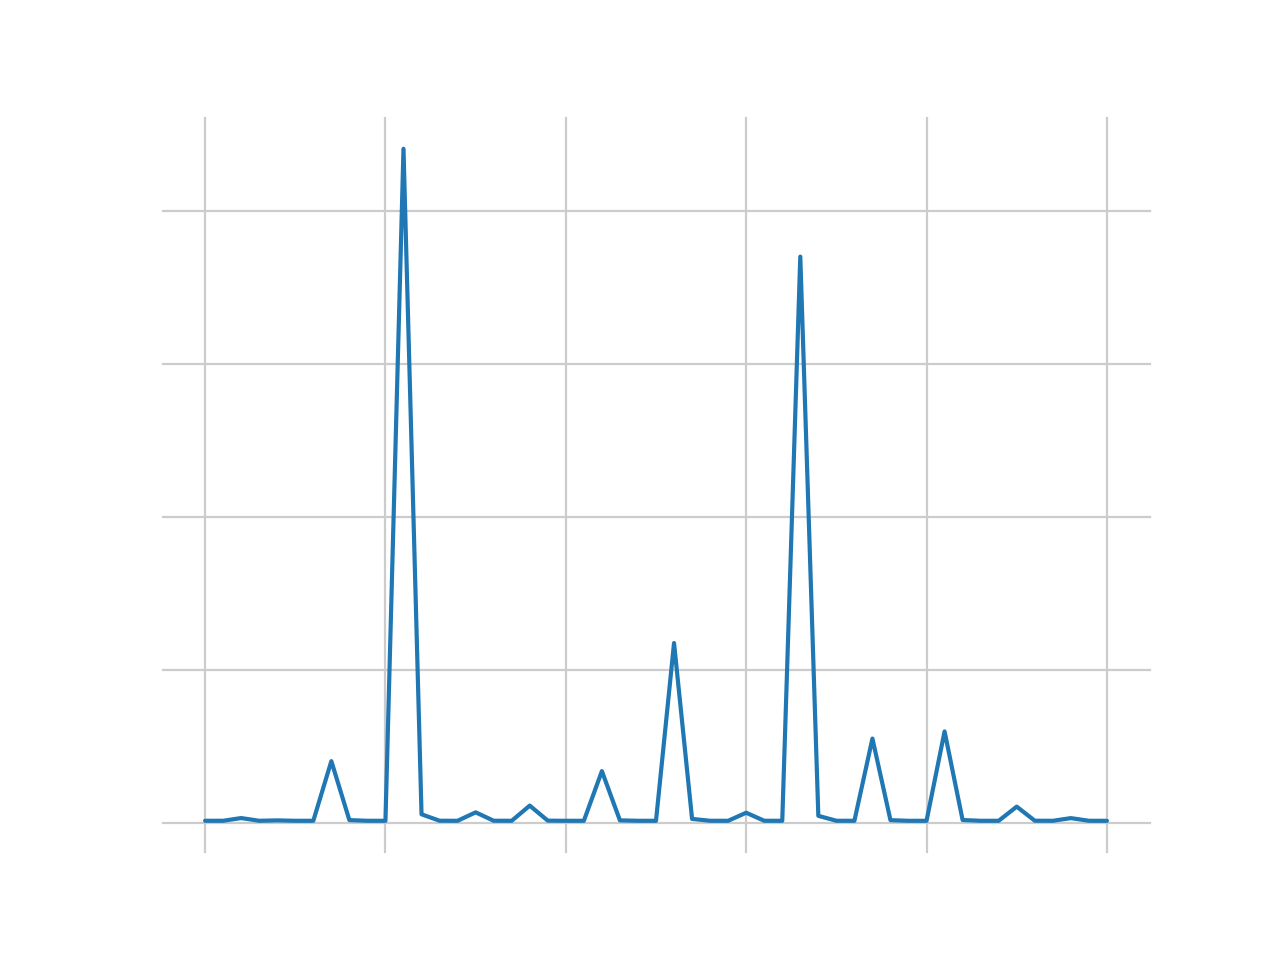

<IPython.core.display.Javascript object>


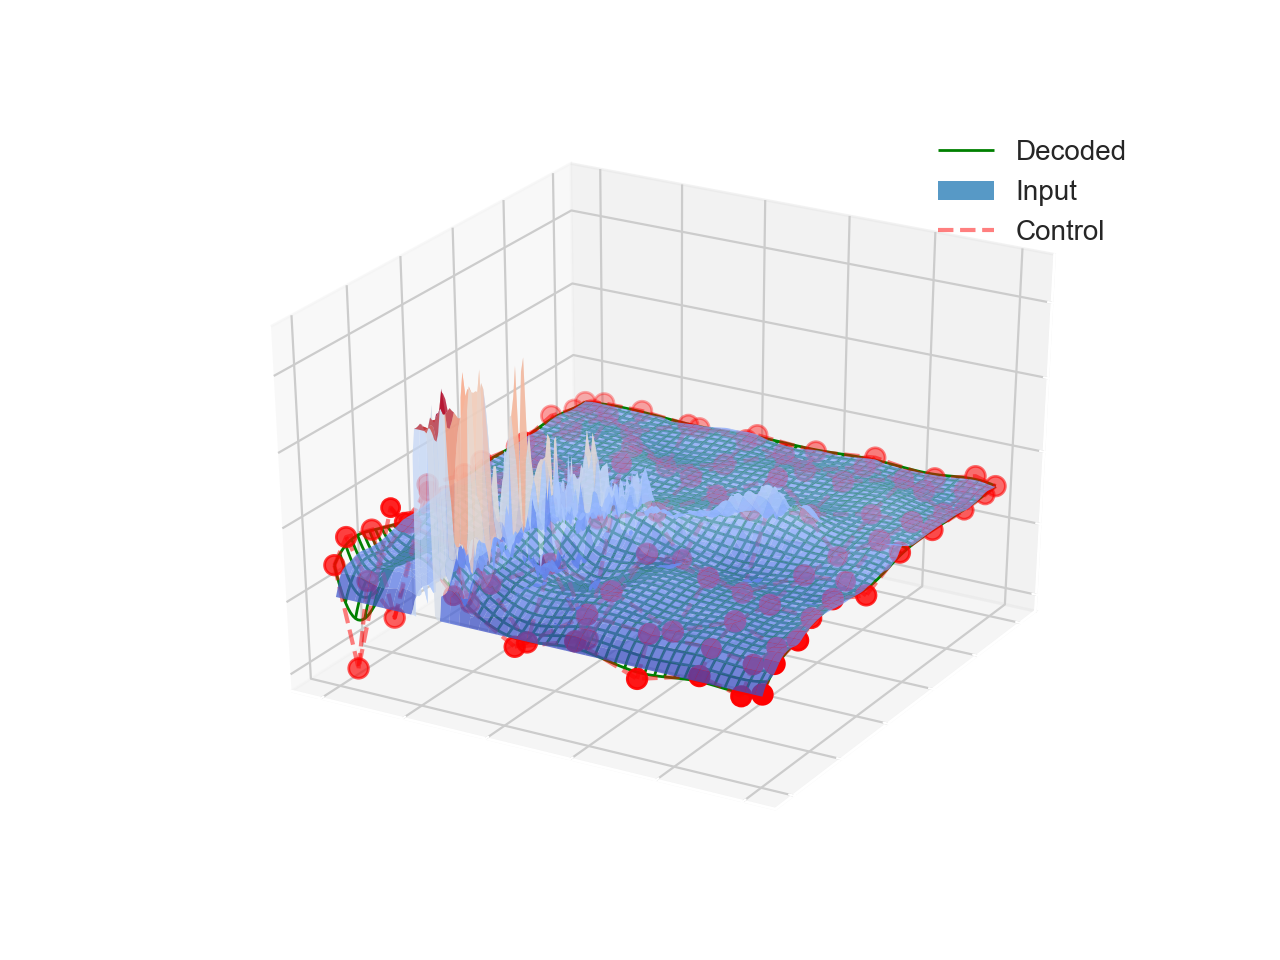

Ctrl points: (10, 10)
Sum of squared error: 7728313.320675534
Normalized mean squared error: 0.9753324207982648
Normalized max error: 0.746160700886166


In [12]:
import tensorflow as tf
from multiprocessing import Process, Manager
    
l1RegW = 0

def lossCallback(loss_evaled):
    global errorsWP
    errorsWP.append(loss_evaled)
#     print "Loss:", errorsWP[-1]
#     clear_output(wait=True)
    
def ADOptW(params, solveW=True, optimizer='BFGS', 
           bnds=None, constraints=None, constraintRanges=[]):
    global errorsWP
    errorsWP = []
    
    P_t = tf.Variable(params['P'], dtype=tf.float32, name="P")
    W_t = tf.Variable(params['W'], dtype=tf.float32, name="W") if solveW else\
          tf.constant(params['W'], dtype=tf.float32)  
    Z_t = tf.constant(params['z'], dtype=tf.float32)
       
    with tf.name_scope("NURBS"):
        Nu = params['Nu'][...,np.newaxis]
        Nv = params['Nv'][:,np.newaxis]
        NN = []
        for ui in range(Nu.shape[0]):
            for vi in range(Nv.shape[0]):
              NN.append(Nu[ui]*Nv[vi])  
        NN = np.array(NN, dtype=np.float32)
#         NURBS = tf.map_fn(lambda n: tf.reduce_sum(n*P_t*W_t)/tf.reduce_sum(n*W_t),NN,
#                          parallel_iterations=8)
        NURBS = tf.tensordot(NN, P_t * W_t, axes=2) / tf.tensordot(NN, W_t, axes=2)
        NURBS = tf.reshape(NURBS, Z_t.shape)

    with tf.name_scope("Loss"):
        residual = (Z_t-NURBS)
        loss = tf.reduce_sum(tf.square(residual)) + l1RegW*tf.reduce_max(tf.abs(residual))
    
    equalities = []
    for CR in constraintRanges:
        for i in itertools.product(range(CR[0][0],CR[1][0]),
                               range(CR[0][1],CR[1][1])):
                equalities.append( P_t[i] - constraints[0][i] )
                if solveW:
                    equalities.append( W_t[i] - constraints[1][i] )
        
    minBounds = [x[0] for x in bnds] if bnds is not None else -np.infty
    maxBounds = [x[1] for x in bnds] if bnds is not None else np.infty
    
    init_op = tf.global_variables_initializer()
    
    config = tf.ConfigProto()#device_count = {'GPU': 0})
#     config = tf.ConfigProto(allow_soft_placement=True)
#     config.gpu_options.allocator_type = 'BFC'
#     config.gpu_options.per_process_gpu_memory_fraction = 0.90
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss, method=optimizer, 
                                                       equalities=equalities, 
                                                       var_to_bounds={W_t: (minBounds, maxBounds)})
    sess.run(init_op)
   
    optimizer.minimize(sess, loss_callback=lossCallback, fetches=[loss])
    params['P'] = sess.run(P_t)
    params['W'] = sess.run(W_t)
    decoded = sess.run(NURBS)
    sess.close()
    tf.reset_default_graph()
    
    params['EList'] += errorsWP
    return decoded

def findPW_AD(P0, W0, z, degree, Nu, Nv, optimizer='SLSQP', 
              constraints=None, constraintRanges=[], weighted=True):
    errorsWP = [SSE(P0, W0, z, degree, Nu, Nv)]
    optParams ={'P':P0, 'W':W0, 'Nu':Nu, 'Nv':Nv, 
                'z':z, 'degree':degree, 'EList':errorsWP}
    wbounds = np.array([ [(1e-1,1) for w in wr] for wr in W0]).swapaxes(1,2)
    decoded = ADOptW(optParams, optimizer=optimizer, bnds=wbounds, solveW=weighted,
                    constraints=constraints, constraintRanges=constraintRanges)
    return optParams['P'], optParams['W'], optParams['EList'], decoded

PH, W0, errorsWP, decoded = findPW_AD(popt, W, z, degree, Nu, Nv, weighted=True)

plt.figure()
plt.plot(errorsWP)
plt.show()

plotFit3D(Nu, Nv, PH, W0, knotsU, knotsV, x, y, z, degree, decoded=decoded)
printFitStats(PH, W0, z, degree, Nu, Nv, decoded=decoded)

### Adaptive fitting by splitting knot spans

Adaptive iteration 1, at 9.885934e-01 maxError
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: 4729097.500000
  Number of iterations: 64
  Number of functions evaluations: 208
decodedError =  [[ 1.81175327e+01  2.82761574e+00 -7.31940937e+00 ...  2.92371035e+00
   3.16339445e+00  3.42029810e+00]
 [ 1.71565983e+01  3.31071201e+00 -5.62968694e+00 ... -9.60593435e-01
  -1.08130681e+00 -1.26762715e+00]
 [ 1.42992370e+01  9.07085308e-01 -7.64905898e+00 ... -3.14463173e+00
  -3.45386208e+00 -3.87699677e+00]
 ...
 [ 6.37320045e-02  1.51808753e-02 -7.34531309e-02 ...  6.06248066e-01
   6.54017322e-01  5.47370311e-01]
 [-3.86488070e-01 -5.04924594e-01 -6.34919728e-01 ...  1.19249513e+00
   1.26528640e+00  1.10847735e+00]
 [-9.67395782e-01 -1.22029786e+00 -1.45709110e+00 ...  1.73051074e+00
   1.84962889e+00  1.51671982e+00]]
reuseE =  [[9.84266004e-01 2.39748090e-02 1.60644718e-01 ... 2.56320337e-02
  3.00068960e-02 3.50

<IPython.core.display.Javascript object>


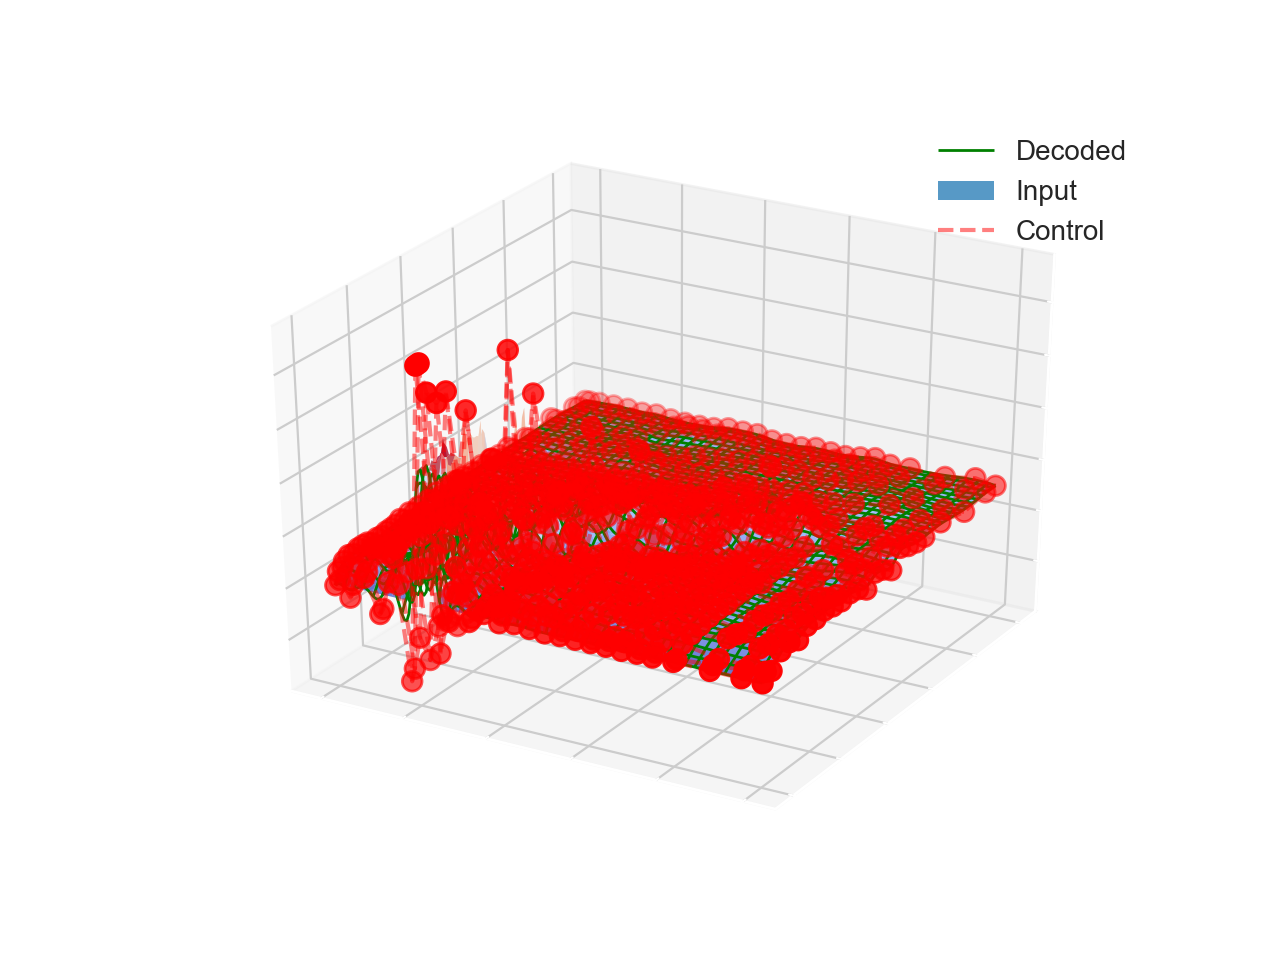

time(s) : 1162.6625658919802
Ctrl points: (25, 27)
Sum of squared error: 2305243.954360929
Normalized mean squared error: 0.2909275379043351
Normalized max error: 0.4808103864762424


In [20]:
import collections
import timeit

def rint(x):
    return int(round(x))

def toHomogeneous(P, W):
    return np.stack( ((P*W), W), axis=2)

def fromHomogeneous(PW):
    P = PW[...,0]
    W = PW[...,1]
    return P/W, W

def getSplits(T, U):
    t = T[degree:-degree]
    toSplit = [((t[:-1]<=u) * (u<=t[1:])).astype(np.float) for u in U]
    toSplit = np.array(toSplit).ravel()
    splitSize = t.shape[0]-1
    splits = []
    for i in range(0, toSplit.shape[0], splitSize):
        splits.append(toSplit[i:i+splitSize])
    toSplit = np.unique(np.array([np.unique(np.where(split))[0] for split in splits]))
    toSplit += degree
    return toSplit

def splitT(T, toSplit, nPoints):
    Tnew = []
    for ti,tval in enumerate(T):
        TnewVal = tval.copy()
        Tnew.append(TnewVal);
        if ti in toSplit:
            inc = (float(T[ti+1]-tval)/2.)
            if ((TnewVal+inc)*nPoints) - (TnewVal*nPoints) < 2:
                print ("Not enough input points to split", TnewVal, T[ti+1])
                toSplit.remove(ti)
                continue
            Tnew.append(TnewVal+inc)
    return np.array(Tnew)

def knotInsert(TU, TV, us, splitUs=True, r=1):
    toSplitU = set(getSplits(TU, us[...,0]))
    toSplitV = set(getSplits(TV, us[...,1]))
    return splitT(TU, toSplitU, nPointsX), splitT(TV, toSplitV, nPointsY), toSplitU, toSplitV
               
def knotRefine(P, W, TU, TV, U, V, r=1, find_all=True, MAX_ERR = 1e-2, reuseE=None):
    NSE = reuseE
    if NSE is None:
        Nu = basis(U[np.newaxis,:],degree,TU[:,np.newaxis]).T
        Nv = basis(V[np.newaxis,:],degree,TV[:,np.newaxis]).T
        NSE = (Error(P, W, z, degree, Nu, Nv)**2)/zRange
    NMSE = NSE.mean()
    if(NMSE<=MAX_ERR):
        return TU, TV, [], [], NSE, NMSE
    if find_all:
        rows,cols = np.where( NSE>=MAX_ERR )
        us = np.vstack( (U[rows] , V[cols]) ).T
    else:
        maxRow,maxCol = np.unravel_index(np.argmax(NSE), NSE.shape)
        NSE[maxRow,maxCol] = 0
        us = np.array([[U[maxRow],V[maxCol]]])
    TUnew,TVnew,Usplits,Vsplits=knotInsert(TU, TV, us, splitUs=find_all, r=r)
    return TUnew,TVnew,Usplits,Vsplits,NSE,NMSE

def insert_knot_u(P, W, T, u, k, degree, r=1, s=0):
    # Algorithm A5.3
    NP = np.array(P.shape)
    Q = np.zeros( (NP[0]+r, NP[1], 2) )
    # Initialize a local array of length p + 1
    R = np.zeros( (degree+1, 2) )
    PW = toHomogeneous(P, W)

    # Save the alphas
    alpha = [[0.0 for _ in range(r + 1)] for _ in range(degree - s)]
    for j in range(1, r + 1):
        L = k - degree + j
        for i in range(0, degree - j - s + 1):
            alpha[i][j] = (u - T[L + i]) / (T[i + k + 1] - T[L + i])

    # Update control points
    for row in range(0, NP[1]):
        for i in range(0, k - degree + 1):
            Q[i][row] = PW[i][row]
        for i in range(k - s, NP[0]):
            Q[i + r][row] = PW[i][row]
        # Load auxiliary control points
        for i in range(0, degree - s + 1):
            R[i] = (PW[k - degree + i][row]).copy()
        # Insert the knot r times
        for j in range(1, r + 1):
            L = k - degree + j
            for i in range(0, degree - j - s + 1):
                R[i][:] = [alpha[i][j] * elem2 + (1.0 - alpha[i][j]) * elem1
                           for elem1, elem2 in zip(R[i], R[i + 1])]
            Q[L][row] = R[0].copy()
            Q[k + r - j - s][row] = R[degree - j - s].copy()
        # Load the remaining control points
        L = k - degree + r
        for i in range(L + 1, k - s):
            Q[i][row] = R[i - L].copy()

    return Q

def insert_knot_v(P, W, T, u, k, degree, r=1, s=0):
    # Algorithm A5.3
    NP = np.array(P.shape)
    Q = np.zeros( (NP[0], NP[1]+r, 2) )
    # Initialize a local array of length p + 1
    R = np.zeros( (degree+1, 2) )
    PW = toHomogeneous(P, W)

    # Save the alphas
    alpha = [[0.0 for _ in range(r + 1)] for _ in range(degree - s)]
    for j in range(1, r + 1):
        L = k - degree + j
        for i in range(0, degree - j - s + 1):
            alpha[i][j] = (u - T[L + i]) / (T[i + k + 1] - T[L + i])

    # Update control points
    for col in range(0, NP[0]):
        for i in range(0, k - degree + 1):
            Q[col][i] = PW[col][i]
        for i in range(k - s, NP[1]):
            Q[col][i + r] = PW[col][i]
        # Load auxiliary control points
        for i in range(0, degree - s + 1):
            R[i] = (PW[col][k - degree + i]).copy()
        # Insert the knot r times
        for j in range(1, r + 1):
            L = k - degree + j
            for i in range(0, degree - j - s + 1):
                R[i][:] = [alpha[i][j] * elem2 + (1.0 - alpha[i][j]) * elem1
                           for elem1, elem2 in zip(R[i], R[i + 1])]
            Q[col][L] = R[0].copy()
            Q[col][k + r - j - s] = R[degree - j - s].copy()
        # Load the remaining control points
        L = k - degree + r
        for i in range(L + 1, k - s):
            Q[col][i] = R[i - L].copy()

    return Q
    
def deCasteljau(P, W, TU, TV, u, k, r=1):
    Qu = insert_knot_u(P, W, TU, u[0], k[0], degree, r)
    P,W= fromHomogeneous(Qu)
    Q  = insert_knot_v(P, W, TV, u[1], k[1], degree, r)
    P,W = fromHomogeneous(Q)
    return P,W

def adaptive(P, W, TU, TV, U, V, z, strategy='extend', weighted=False,
             r=1, MAX_ERR=1e-2, MAX_ITER=1000, split_all=False, decodedError=None):
    start_time = timeit.default_timer()
    k = []
    r = min(r,degree) #multiplicity can not be larger than degree
    fevals = 0
    reuseE = (decodedError**2)/zRange if decodedError is not None else None
    iteration = 0
    while iteration < MAX_ITER:
        fev = 0
        TUnew,TVnew,Usplits,Vsplits,E,maxE = knotRefine(P, W, TU, TV, U, V,
                                                        r, reuseE=reuseE,
                                                        MAX_ERR=MAX_ERR, 
                                                        find_all=split_all)
        print ("Adaptive iteration %d, at %e maxError"%(iteration+1,maxE))
        if len(Usplits)==0 or len(Vsplits)==0:
            if (maxE>MAX_ERR):
                reuseE = E
                continue
        if(maxE<=MAX_ERR):
            k = [-1, -1]
            print ("Adaptive done in %d iterations at %e maxError"%(iteration+1,maxE))
            break
        if strategy == 'extend' and not split_all:   #only use when coupled with a solver
            k = [Usplits.pop(),Vsplits.pop()] #if reuseE is None else [-1,-1]
            u = np.array([TUnew[k[0]+1],TVnew[k[1]+1]])
            P,W = deCasteljau(P, W, TU, TV, u, k, r)
        elif strategy == 'reset':
            nControlPoints = np.array([TUnew.shape[0]-1-degree, TVnew.shape[0]-1-degree])
            Nu = basis(U[np.newaxis,:],degree,TUnew[:,np.newaxis]).T
            Nv = basis(V[np.newaxis,:],degree,TVnew[:,np.newaxis]).T

            W = np.ones( nControlPoints )
            #P,_ = lsqFit(Nu, Nv, W, z, degree)
            P,W,errs,decoded = findPW_AD(W, W, z, degree, Nu, Nv, weighted=weighted)
            decodedError = decoded-z
            print("decodedError = ", decodedError)
            reuseE = (decodedError**2)/zRange
            fev = len(errs)
        else:
            print ("Not Implemented!!")
        print("reuseE = ", reuseE)
        TU = TUnew
        TV = TVnew
        fevals += fev*(P.size+z.size)
        iteration += 1
        
    return P, W, TU, TV, (timeit.default_timer()-start_time), np.array([k]), decodedError

PA, WA, knotsA_U, knotsA_V, fevals,_,E = adaptive(popt, W, knotsU, knotsV, U, V, z, 
                                                MAX_ERR=5e-1, 
                                                split_all=True, strategy='reset', 
                                                weighted=False,
                                                MAX_ITER=50)
NuA = basis(U[np.newaxis,:],degree,knotsA_U[:,np.newaxis]).T
NvA = basis(V[np.newaxis,:],degree,knotsA_V[:,np.newaxis]).T
decoded = E+z
plotFit3D(NuA, NvA, PA, WA, knotsA_U, knotsA_V, x, y, z, degree, decoded=decoded)
print ("time(s) :", fevals)
printFitStats(PA, WA, z, degree, NuA, NvA, decoded=decoded)

## Local weight solve+Adaptive knot span splitting, iterative

In [16]:
# %%pixie_debugger

def adaptiveFitLocal(PH, W0, TU, TV, z, U, V, degree, C=degree, RMAX_ERR=1e-2, NURBS=True):
    start_time = timeit.default_timer()
#     order = degree+1
#     T = np.concatenate(([0.]*order, [1.]*order))
#     T = np.array([T,T]).T
    Nu = basis(U[np.newaxis,:],degree,TU[:,np.newaxis]).T
    Nv = basis(V[np.newaxis,:],degree,TV[:,np.newaxis]).T
#     W0 = np.ones( (order, order) )
#     PH = lsqFit(Nu, Nv, W0, z, degree)
    fevals = 0
    decodedError = Error(PH, W0, z, degree, Nu, Nv)
    nmse = (decodedError**2).mean()/zRange
    globalSolve = False
    while nmse>RMAX_ERR:
        print ("NMSE:", nmse)
        PNew, W0, TU, TV, _, ks, decodedError = adaptive(PH, W0, TU, TV, U, V, z, 
                                         MAX_ERR=RMAX_ERR, strategy='extend', 
                                         MAX_ITER=1, split_all=False, r=1,
                                         decodedError=decodedError)
        if PNew.size == PH.size:
            if globalSolve:
                print ("Failed to split any knot spans!!")
                break
        PH = PNew
        Nu = basis(U[np.newaxis,:],degree,TU[:,np.newaxis]).T
        Nv = basis(V[np.newaxis,:],degree,TV[:,np.newaxis]).T
        S = np.array(PH.shape)
        for k in ks:
            if np.all(k>=0):
                addedPs = k-degree+1
                addedPe = k+1
                print ("Max Error is at span:", k, addedPs, addedPe)
                ps = np.maximum(addedPs-C,np.array([0,0]))
                pe = np.minimum(addedPe+C,S)
                
                #make it a tensor product (square)
                aspect = (pe[1]-ps[1])-(pe[0]-ps[0])
                while aspect != 0:
                    if aspect>=0:
                        pe[0] += aspect  
                    else:
                        pe[1] += -aspect
                    if np.any(pe > S):
                        shift = abs(aspect)
                        ps = np.maximum(ps-shift,np.array([0,0]))
                        pe -= shift
                        addedPs = np.maximum(addedPs-shift,np.array([0,0]))
                        addedPe -= shift
                    aspect = (pe[1]-ps[1])-(pe[0]-ps[0])

                CTopLeft     = np.where(addedPs<C,0,C)
                CBottomRight = np.where(pe-addedPe<C,0,C)
                print ("Total local solve", ps,pe)
                print ("Unconstrained", ps+CTopLeft, pe-CBottomRight)
                print ("Constrains", CTopLeft, CBottomRight)
                globalSolve = False
            else: #perform a global solve
                print ("Couldn't split a span. Unconstrained global solve.")
                ps = np.array([0,0])
                pe = S
                CTopLeft     = ps
                CBottomRight = ps
                globalSolve = True
            
#             tu = TU[ps[0]:pe[0]+degree+1]
#             tv = TV[ps[1]:pe[1]+degree+1] 
#             coeffs_x = getControlPoints(tu, degree)
#             coeffs_y = getControlPoints(tv, degree)
#             ui = np.all((U>=coeffs_x[0], U<=coeffs_x[-1]), axis=0)
#             vi = np.all((V>=coeffs_y[0], V<=coeffs_y[-1]), axis=0)
#             crop = ui[:,np.newaxis] * vi[np.newaxis,:]
            NuTemp = Nu.copy()
            NvTemp = Nv.copy()
            NuTemp[:,:ps[0]+CTopLeft[0]] = 0
            NvTemp[:,:ps[1]+CTopLeft[1]] = 0
            NuTemp[:,pe[0]-CBottomRight[0]:] = 0
            NvTemp[:,pe[1]-CBottomRight[1]:] = 0
            crop = (np.sum(NuTemp, axis=1))[:,np.newaxis] * (np.sum(NvTemp, axis=1))[np.newaxis,:]
            
            crop = np.array(np.nonzero(crop))
            cropS = crop.min(axis=1)
            cropE = crop.max(axis=1)+1
            
            nu = Nu[cropS[0]:cropE[0], ps[0]:pe[0]]
            nv = Nv[cropS[1]:cropE[1], ps[1]:pe[1]]
            ww = W0[ps[0]:pe[0],ps[1]:pe[1]].copy()
            pp = PH[ps[0]:pe[0],ps[1]:pe[1]].copy()
            zz = z[cropS[0]:cropE[0],cropS[1]:cropE[1]]

            NE        = ww.shape
            constraintRanges = []
            constraintRanges.append( ([0,0],[NE[0]-CBottomRight[0],CTopLeft[1]]) )#left strip
            constraintRanges.append( ([0,CTopLeft[1]],[CTopLeft[0],NE[1]]) )      #top strip
            constraintRanges.append( ([0+CTopLeft[0],NE[1]-CBottomRight[1]],NE) ) #right strip
            constraintRanges.append( ([NE[0]-CBottomRight[0],0],[NE[0],NE[1]-CBottomRight[1]]) ) #bottom
            
            print (nu.shape, nv.shape, pp.shape, PH.shape)
            cons = [pp,ww]
            pp, ww, errorsWP,decoded = findPW_AD(pp, ww, zz, degree, nu, nv,
                                        optimizer='SLSQP', weighted=NURBS,
                                        constraintRanges=constraintRanges, 
                                        constraints=cons)
            
            PH[ps[0]:pe[0],ps[1]:pe[1]] = pp.copy()
            W0[ps[0]:pe[0],ps[1]:pe[1]] = ww.copy()
            
            decodedError[cropS[0]:cropE[0],cropS[1]:cropE[1]] = decoded-zz
            fevals   += len(errorsWP)*(pp.size+zz.size)
        nmse = (decodedError**2).mean()/zRange
    return TU, TV, PH, W0, PH.shape, decodedError, (timeit.default_timer()-start_time)#fevals


TUnew, TVnew, Plocal, Wlocal, nCtrlPts, E, fevals = adaptiveFitLocal(popt, W, knotsU, knotsV,
                                                                  z, U, V, degree, 
                                                                  C=degree, RMAX_ERR=1e-2, 
                                                                  NURBS=True)
decoded = E+z
Nu = basis(U[np.newaxis,:],degree,TUnew[:,np.newaxis]).T
Nv = basis(V[np.newaxis,:],degree,TVnew[:,np.newaxis]).T

plotFit3D(Nu, Nv, Plocal, Wlocal, TUnew, TVnew, x, y, z, degree, decoded=decoded)
print ("time(s) :", fevals)
printFitStats(Plocal, Wlocal, z, degree, Nu, Nv, decoded=decoded)

NMSE: 0.9885933949669463
Adaptive iteration 1, at 9.885934e-01 maxError
Max Error is at span: [5 4] [3 2] [6 5]
Total local solve [0 0] [9 9]
Unconstrained [3 0] [6 6]
Constrains [3 0] [3 3]
(95, 9) (126, 9) (9, 9) (11, 11)


KeyboardInterrupt: 

In [ ]:
NURBS = True

POrig = PH if NURBS else popt
WOrig = W0 if NURBS else W
WTest = WOrig.copy()
PTest = POrig.copy()
T  = knots.copy()
S = np.array(PTest.shape)
C = degree
addedPs = np.array([4,5])
addedPe = np.array([5,6])
print ("Max Error is at span:", addedPs, addedPe)

ps = np.maximum(addedPs-C,np.array([0,0]))
pe = np.minimum(addedPe+C,S)

#make it a tensor product (square)
aspect = (pe[1]-ps[1])-(pe[0]-ps[0])
while aspect != 0:
    if aspect>=0:
        pe[0] += aspect  
    else:
        pe[1] += -aspect
    if np.any(pe > S):
        shift = abs(aspect)
        ps = np.maximum(ps-shift,np.array([0,0]))
        pe -= shift
        addedPs = np.maximum(addedPs-shift,np.array([0,0]))
        addedPe -= shift
    aspect = (pe[1]-ps[1])-(pe[0]-ps[0])

CTopLeft     = np.where(addedPs<C,0,C)
CBottomRight = np.where(pe-addedPe<C,0,C)
print ("Total local solve", ps,pe)
print ("Unconstrained", ps+CTopLeft, pe-CBottomRight)
print( "Constrained", CTopLeft, CBottomRight)

t = np.array([T[...,0][ps[0]:pe[0]+degree+1],T[...,1][ps[1]:pe[1]+degree+1]]).T 
coeffs_x = getControlPoints(t, degree)
ui = np.all((U>=coeffs_x[...,0][0], U<=coeffs_x[...,0][-1]), axis=0)
vi = np.all((V>=coeffs_x[...,1][0], V<=coeffs_x[...,1][-1]), axis=0)
crop = ui[:,np.newaxis] * vi[np.newaxis,:]

# Nu = basis(U[np.newaxis,:],degree,T[:,np.newaxis][...,0]).T
# Nv = basis(V[np.newaxis,:],degree,T[:,np.newaxis][...,1]).T
# Nu[:,:addedPs[0]] = 0
# Nv[:,:addedPs[1]] = 0
# Nu[:,addedPe[0]:] = 0
# Nv[:,addedPe[1]:] = 0
# crop = (np.sum(Nu, axis=1))[:,np.newaxis] * (np.sum(Nv, axis=1))[np.newaxis,:]

crop = np.array(np.nonzero(crop))
cropS = crop.min(axis=1)
cropE = crop.max(axis=1)+1

nu = Nu[cropS[0]:cropE[0], ps[0]:pe[0]]
nv = Nv[cropS[1]:cropE[1], ps[1]:pe[1]]
ww = WTest[ps[0]:pe[0],ps[1]:pe[1]].copy()
pp = PTest[ps[0]:pe[0],ps[1]:pe[1]].copy()
zz = z[cropS[0]:cropE[0],cropS[1]:cropE[1]]

print nu.shape, nv.shape, pp.shape, zz.shape

NE        = ww.shape
constraintRanges = []
constraintRanges.append( ([0,0],[NE[0]-CBottomRight[0],CTopLeft[1]]) )#left strip
constraintRanges.append( ([0,CTopLeft[1]],[CTopLeft[0],NE[1]]) )      #top strip
constraintRanges.append( ([0+CTopLeft[0],NE[1]-CBottomRight[1]],NE) ) #right strip
constraintRanges.append( ([NE[0]-CBottomRight[0],0],[NE[0],NE[1]-CBottomRight[1]]) ) #bottom strip

if NURBS:
    cons      = [pp,ww]
    pp, ww, errorsWP = findPW_AD(pp, ww, zz, degree, nu, nv,
                                optimizer='SLSQP',
                                constraintRanges=constraintRanges, 
                                constraints=cons)
else:
    lsqFitCons = []
    for CR in constraintRanges:
        lsqCon = [{'type':'eq', 'fun': lambda x, i=i: x.reshape(NE)[i]-pp[i]} 
                            for i in itertools.product(range(CR[0][0],CR[1][0]),
                                                       range(CR[0][1],CR[1][1]))]
        lsqFitCons += lsqCon
    pp,errorsWP   = lsqFit(nu, nv, ww, zz, degree, constraints=lsqFitCons).reshape(NE)

PTest[ps[0]:pe[0],ps[1]:pe[1]] = pp.copy()
WTest[ps[0]:pe[0],ps[1]:pe[1]] = ww.copy()


## Plotting
plt.figure()
plt.plot(errorsWP)
plt.show()

#
Nu = basis(U[np.newaxis,:],degree,T[:,np.newaxis][...,0]).T
Nv = basis(V[np.newaxis,:],degree,T[:,np.newaxis][...,1]).T

E_before =  decode(POrig, WOrig, degree, Nu, Nv)
E_after = decode(PTest, WTest, degree, Nu, Nv)
X, Y = np.meshgrid(x, y)
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, E_before-E_after, cmap=cm.coolwarm,
                   linewidth=0, antialiased=True)
coeffs_x = getControlPoints(T, degree) * (Dmax - Dmin) + Dmin
X, Y = np.meshgrid(coeffs_x[:,0], coeffs_x[:,1])
ax.plot_wireframe(X, Y, POrig-PTest, alpha=1, linestyle='--', color='r', label='Control')
pointSize = abs(WOrig-WTest)
print "Max W diff %e"%pointSize.max()
ax.scatter(X, Y, POrig-PTest,color='r', alpha=1, s=(pointSize/pointSize.max())*50)
fig.colorbar(surf)
plt.show()
#

print ("New ctrl points:", PTest.shape)
print ("Sum of squared error:", SSE(PTest, WTest, z, degree, Nu, Nv))
print ("Normalized max error:", NMaxError(PTest, WTest, z, degree, Nu, Nv))

#check for constraint equality after convergence
newPW = toHomogeneous(pp, ww)
oldPW = toHomogeneous(POrig, WOrig)[ps[0]:pe[0],ps[1]:pe[1]]

for CR in constraintRanges:
    for i in itertools.product(range(CR[0][0],CR[1][0]),
                               range(CR[0][1],CR[1][1])):
        if np.any(newPW[i] != oldPW[i]):
            print ("Constraints not satisfied", i, newPW[i], oldPW[i])

In [ ]:
ps = [2,6]
pe = [6,10]

t = np.array([T[...,0][ps[0]:pe[0]+degree+1],T[...,1][ps[1]:pe[1]+degree+1]]).T 
coeffs_x = getControlPoints(t, degree)
ui = np.all((U>=coeffs_x[...,0][0], U<=coeffs_x[...,0][-1]), axis=0)
vi = np.all((V>=coeffs_x[...,1][0], V<=coeffs_x[...,1][-1]), axis=0)
crop = ui[:,np.newaxis] * vi[np.newaxis,:]

# Nu = basis(U[np.newaxis,:],degree,T[:,np.newaxis][...,0]).T
# Nv = basis(V[np.newaxis,:],degree,T[:,np.newaxis][...,1]).T
# Nu[:,:addedPs[0]] = 0
# Nv[:,:addedPs[1]] = 0
# Nu[:,addedPe[0]:] = 0
# Nv[:,addedPe[1]:] = 0
# crop = (np.sum(Nu, axis=1))[:,np.newaxis] * (np.sum(Nv, axis=1))[np.newaxis,:]
crop = np.array(np.nonzero(crop))

In [ ]:
colors = np.zeros_like(PH)
for i in itertools.product(range(ps[0],pe[0]),
                           range(ps[1],pe[1])):
        colors[i] = 10.
for i in itertools.product(range(addedPs[0],addedPe[0]),
                           range(addedPs[1],addedPe[1])):
        colors[i] = 60.
for ci,CR in enumerate(constraintRanges):
    for i in itertools.product(range(CR[0][0],CR[1][0]),
                               range(CR[0][1],CR[1][1])):
        index = tuple(ps+i)
        colors[index] = 20.

fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(x, y)
surf = ax.plot_surface(Y, X, (E_before-E_after), cmap=cm.jet, alpha=0.2,
           linewidth=0, antialiased=True)
fig.colorbar(surf)
coeffs_x = getControlPoints(T, degree) * (Dmax - Dmin) + Dmin
X, Y = np.meshgrid(coeffs_x[:,0], coeffs_x[:,1])
ax.scatter(Y, X, 1, alpha=1, c=colors.flatten())
plt.show()

print colors

In [ ]:
import tensorflow as tf
import horovod.tensorflow as hvd

P_t = tf.Variable(popt, dtype=tf.float32, name="P")
W_t = tf.Variable(W, dtype=tf.float32, name="W")
Z_t = tf.constant(z, dtype=tf.float32)

with tf.name_scope("NURBS"):
    Nuu = Nu[...,np.newaxis]
    Nvv = Nv[:,np.newaxis]
    NN = []
    for ui in range(Nuu.shape[0]):
        for vi in range(Nvv.shape[0]):
          NN.append(Nuu[ui]*Nvv[vi])  
    NN = np.array(NN, dtype=np.float32)
#         NURBS = tf.map_fn(lambda n: tf.reduce_sum(n*P_t*W_t)/tf.reduce_sum(n*W_t),NN,
#                          parallel_iterations=8)
    NURBS = tf.tensordot(NN, P_t * W_t, axes=2) / tf.tensordot(NN, W_t, axes=2)
    NURBS = tf.reshape(NURBS, Z_t.shape)

with tf.name_scope("Loss"):
    residual = (Z_t-NURBS)
    loss = tf.reduce_sum(tf.square(residual))

init_op = tf.global_variables_initializer()

# Initialize Horovod
hvd.init()

#     config = tf.ConfigProto(device_count = {'GPU': 0})
config = tf.ConfigProto()
#     config.gpu_options.allocator_type = 'BFC'
#     config.gpu_options.per_process_gpu_memory_fraction = 0.90
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = str(hvd.local_rank())

optimizer =  tf.contrib.opt.ScipyOptimizerInterface(loss, method='L-BFGS-B')
opt = hvd.DistributedOptimizer(optimizer)
train_op = opt.minimize(loss)
hooks = [hvd.BroadcastGlobalVariablesHook(0)]

with tf.train.MonitoredTrainingSession(checkpoint_dir=None,
                                       config=config,
                                       hooks=hooks) as mon_sess:
    while not mon_sess.should_stop():
        # Perform synchronous training.
        mon_sess.run(train_op)
    
    PH = mon_sess.run(P_t)
    W0 = mon_sess.run(W_t)